This is an implementation of the artistic neural network as described in this [paper](https://arxiv.org/abs/1508.06576). VGG pretrained model weights can be downloaded from [here](http://www.vlfeat.org/matconvnet/models/). Use imagenet-vgg-verydeep-19.mat and imagenet-vgg-verydeep-16.mat

In [73]:
from __future__ import print_function
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy as sp
import PIL.Image
from IPython.display import clear_output, Image, display
from io import BytesIO

In [45]:
class VGG(object):
    
    def __init__(self):
        self.input_shape = [1, 600, 800, 3]
        self.graph = None
        self.content_layer = None
        self.style_layer = None
        self.path = None
        self.layer_names = []
    
    def load_model(self):
        """
        The pretrained model contains the layer name and layer type (i.e. pool, conv etc.)
        To access those information, we can do the index access:
        vgg_layers[0]      [0]       [0]      [0]      [2]                                    [0]      [0] ## weight
        vgg_layers[0]      [0]       [0]      [0]      [2]                                    [0]      [1] ## bias
                  always 0 |layer idx|always 0|always 0|0:layer name; 1:layer type; 2: weights|always 0|0:weight; 1:bias
        vgg_layers[0][30][0][0][0][0] # to access layer name
        vgg_layers[0][30][0][0][1][0] # to access layer type
        
        Note that the fully connected layers and the softmax are not required for this task, therefore we will skip it. 
        The fully connected layers have name fc* (It's type is conv though).
        """
        if self.path == None:
            raise Exception("Run from the child class")
            
        vgg_layers = scipy.io.loadmat(self.path)['layers']
        num_layers = len(vgg_layers[0])
        
        graph = {}
        graph["input"] = tf.Variable(np.zeros(self.input_shape), dtype=tf.float32)
        prev = "input"
        self.layer_names.append("input")
        
        for idx in range(num_layers):
            
            layer_name = vgg_layers[0][idx][0][0][0][0]
            layer_type = vgg_layers[0][idx][0][0][1][0]
            
            if layer_name[:2] == "fc":
                break                     # stop before adding the first fc layer
            
            self.layer_names.append(layer_name)
            
            if layer_type == "conv":
                W = vgg_layers[0][idx][0][0][2][0][0]
                b = vgg_layers[0][idx][0][0][2][0][1]
                W = tf.constant(W)        # we don't want to update the parameters
                b = tf.constant(np.reshape(b, (b.size)))
                graph[layer_name] = tf.nn.conv2d(graph[prev], filter=W, strides=[1, 1, 1, 1], padding="SAME") + b
            elif layer_type == "relu":
                graph[layer_name] = tf.nn.relu(graph[prev])
            elif layer_type == "pool":    # according to the paper, average pooling behaves better
                graph[layer_name] = tf.nn.avg_pool(graph[prev], ksize=[1, 2, 2, 1], 
                                                   strides=[1, 2, 2, 1], padding="SAME")
            
            prev = layer_name
        self.graph = graph
        
    def gram_matrix(self, F, N, M):
        """
        The gram matrix G.
        F -- the features
        N -- number of filters
        M -- hight x width of one feature map 
        Names as per paper
        """
        F = tf.reshape(F, (M, N))
        return tf.matmul(tf.transpose(F), F)
    
    def content_loss(self, sess, content_img):
        """
        Compute the context loss as described in the paper. We only need to do the forward 
        pass once on the content image
        
        sess -- the current session
        content_img -- the content image. should be a numpy array with dimension [1, hight, width, 3]
        Note: the dimension of the image should match with the one set at resize_input.
        Also, the image should be centered. The mean should be the training set mean of the VGG network.
        """
        if content_img.shape != self.input_shape:
            raise Exception("Dimension doesn't match")
        if self.content_layer == None:
            raise Exception("Call from the child class")
        sess.run(self.graph["input"].assign(content_img))
        P = sess.run(self.graph[self.content_layer])
        F = self.graph[self.content_layer]
        return 0.5 * tf.reduce_sum(tf.pow(F - P, 2))
        
    
    def style_loss(self, sess, style_img):
        """
        Compute the style loss as described in the papaer. Again, only do forward pass once for style image
        
        sess -- the current session
        sytle_image -- the style image. Should be a numpy array
        Note: the style image should also have the same dimension as the content image, either by cropping or 
        some other methods.
        
        The style layers will contain multiple layers. Should be a dictionary with keys are the layer name, 
        and values are the associated weight
        """
        if style_img.shape != self.input_shape:
            raise Exception("Dimension doesn't match")
        if self.style_layer == None:
            raise Exception("Call from child class")
        sess.run(self.graph["input"].assign(style_img))
        loss = 0
        for key in self.style_layer:
            P = sess.run(self.graph[key])
            N = P.shape[3]  # number of filters
            M = P.shape[1] * P.shape[2] # hight x width of one feature map 
            F = self.graph[key]
            A = gram_matrix(P, N, M)
            G = gram_matrix(F, N, M)
            loss += (1 / (4 * N**2 * M**2)) * tf.reduce_sum(tf.pow(G - A, 2)) * self.style_layer[key]
        return loss
        
    def emit(self):
        return self.graph
    
    def resize_input(self, new_shape):
        self.input_shape = new_shape
        tf.reshape(self.graph["input"], new_shape)
    
    def get_layer_names(self):
        return self.layer_names
    
    def get_instance(model_path, force=False):
        raise Exception("Do not instantiate this class")

In [39]:
class VGG19(VGG):
    
    instance = None
    
    def __init__(self, model_path):
        super(VGG19, self).__init__()
        self.path = model_path
        self.graph = self.load_model()
        self.content_layer = "relu4_2"
        self.style_layer = {
            "relu1_1": 0.5,
            "relu2_1": 1.0,
            "relu3_1": 1.5,
            "relu4_1": 3.0,
            "relu5_1": 4.0
        }
    
    def get_instance(model_path, force=False):
        """
        Singleton to avoid load graph on every run
        If force is True, then force reload
        """
        if VGG19.instance == None or force:
            VGG19.instance = VGG19(model_path)
        return VGG19.instance
    
    get_instance = staticmethod(get_instance)

In [46]:
class VGG16(VGG):
    
    instance = None
    
    def __init__(self, model_path):
        super(VGG16, self).__init__()
        self.path = model_path
        self.graph = self.load_model()
        self.content_layer = "relu4_2"
        self.style_layer = {
            "relu1_2": 0.5,
            "relu2_2": 1.0,
            "relu3_3": 1.5,
            "relu4_3": 3.0,
            "relu5_3": 4.0
        }
    
    def get_instance(model_path, force=False):
        """
        Singleton to avoid load graph on every run
        If force is True, then force reload
        """
        if VGG16.instance == None or force:
            VGG16.instance = VGG16(model_path)
        return VGG16.instance
    
    get_instance = staticmethod(get_instance)

In [47]:
class VGGFactory(object):
    
    def factory(name, model_path, force=False):
        """
        The factory to create the corresponding model we will use
        Available names include "VGG16" and "VGG19"
        If force is set, then force reload the graph
        """
        if name == "VGG16": return VGG16.get_instance(model_path, force)
        if name == "VGG19": return VGG19.get_instance(model_path, force)
    
    factory = staticmethod(factory)

In [48]:
vgg19 = VGGFactory.factory("VGG19", "models/imagenet-vgg-verydeep-19.mat")
print(vgg19.get_layer_names())
vgg16 = VGGFactory.factory("VGG16", "models/imagenet-vgg-verydeep-16.mat")
print(vgg16.get_layer_names())

['input', u'conv1_1', u'relu1_1', u'conv1_2', u'relu1_2', u'pool1', u'conv2_1', u'relu2_1', u'conv2_2', u'relu2_2', u'pool2', u'conv3_1', u'relu3_1', u'conv3_2', u'relu3_2', u'conv3_3', u'relu3_3', u'conv3_4', u'relu3_4', u'pool3', u'conv4_1', u'relu4_1', u'conv4_2', u'relu4_2', u'conv4_3', u'relu4_3', u'conv4_4', u'relu4_4', u'pool4', u'conv5_1', u'relu5_1', u'conv5_2', u'relu5_2', u'conv5_3', u'relu5_3', u'conv5_4', u'relu5_4', u'pool5']
['input', u'conv1_1', u'relu1_1', u'conv1_2', u'relu1_2', u'pool1', u'conv2_1', u'relu2_1', u'conv2_2', u'relu2_2', u'pool2', u'conv3_1', u'relu3_1', u'conv3_2', u'relu3_2', u'conv3_3', u'relu3_3', u'pool3', u'conv4_1', u'relu4_1', u'conv4_2', u'relu4_2', u'conv4_3', u'relu4_3', u'pool4', u'conv5_1', u'relu5_1', u'conv5_2', u'relu5_2', u'conv5_3', u'relu5_3', u'pool5']


In [94]:
class Paint(object):
    
    # means for RGB channels. I believe it's the training set average for the pretrained model,
    # according to this: https://gist.github.com/ksimonyan/211839e770f7b538e2d8. Also various 
    # sources agree on those values.
    IMG_MEAN = np.array([123.68, 116.779, 103.939], dtype=np.float32) 
    
    def __init__(self):
        self.vgg = None
        self.vgg_name = None
        self.vgg_path = None
        self.alpha = None
        self.beta = None
        self.style = None
        self.content = None
        self.random = None
        
    def _showarray(a, fmt='jpeg'):
        """
        lol, copied from tf deep dream tutorial
        """
        a = np.uint8(np.clip(a, 0, 1)*255)
        f = BytesIO()
        PIL.Image.fromarray(a).save(f, fmt)
        display(Image(data=f.getvalue()))
    
    def set_vgg_name(self, vgg_name):
        self.vgg_name = vgg_name
        return self
    
    def set_vgg_path(self, vgg_path):
        self.vgg_path = vgg_path
        return self
    
    def set_alpha(self, alpha):
        self.alpha = alpha
        return self
        
    def set_beta(self, beta):
        self.beta = beta
        return self
    
    def load(self):
        self.vgg = VGGFactory.factory(self.vgg_name, self.vgg_path)
        return self
    
    def load_style(self, image_path):
        image = PIL.Image.open(image_path)
        image = np.float32(image)
        image -= Paint.IMG_MEAN
        self.style = image
        _showarray(image)
        return self
    
    def load_content(self, image_path):
        image = PIL.Image.open(image_path)
        image = np.float32(image)
        image -= Paint.IMG_MEAN
        self.content = image
        _showarray(image)
        
        # generate the random image with the same shape as the content
        
        self.random = np.random.uniform(-20, 20, image.shape, dtype=np.float32)
        return self
    
    def run(self):
        style_shape = self.style.shape
        content_shape = self.content.shape
        if style_shape[0] < content_shape[0] or style_shape[1] < content_shape[1]:
            raise Exception("Style too small")
        
        # clip the style image
        
        self.style = self.style[(style_shape[0] - content_shape[0]) / 2.0 : style_shape[0] - (style_shape[0] - content_shape[0]) / 2.0] \
                               [(style_shape[1] - content_shape[1]) / 2.0 : style_shape[1] - (style_shape[1] - content_shape[1]) / 2.0] \
                               [:]
        
        # reshape the style, content and random images
        
        self.style = np.reshape(self.style, (1,) + self.style.shape)
        self.content = np.reshape(self.content, (1,) + self.content.shape)
        self.random = np.reshape(self.random, (1,) + self.random.shape)
        
        # resize the input dimension of the VGG network
        
        self.vgg.resize_input(self.content.shape)
        
        sess = tf.InteractiveSession()
        sess.run(tf.initialize_all_variables())
        
        content_loss = self.vgg.content_loss(sess, self.content)
        style_loss   = self.vgg.style_loss(sess, self.style)
        total_loss   = self.alpha * content_loss + self.beta * style_loss
        
        train_step   = tf.train.AdamOptimizer(2.0).minimize(total_loss)
        
        

(780, 1920, 3)


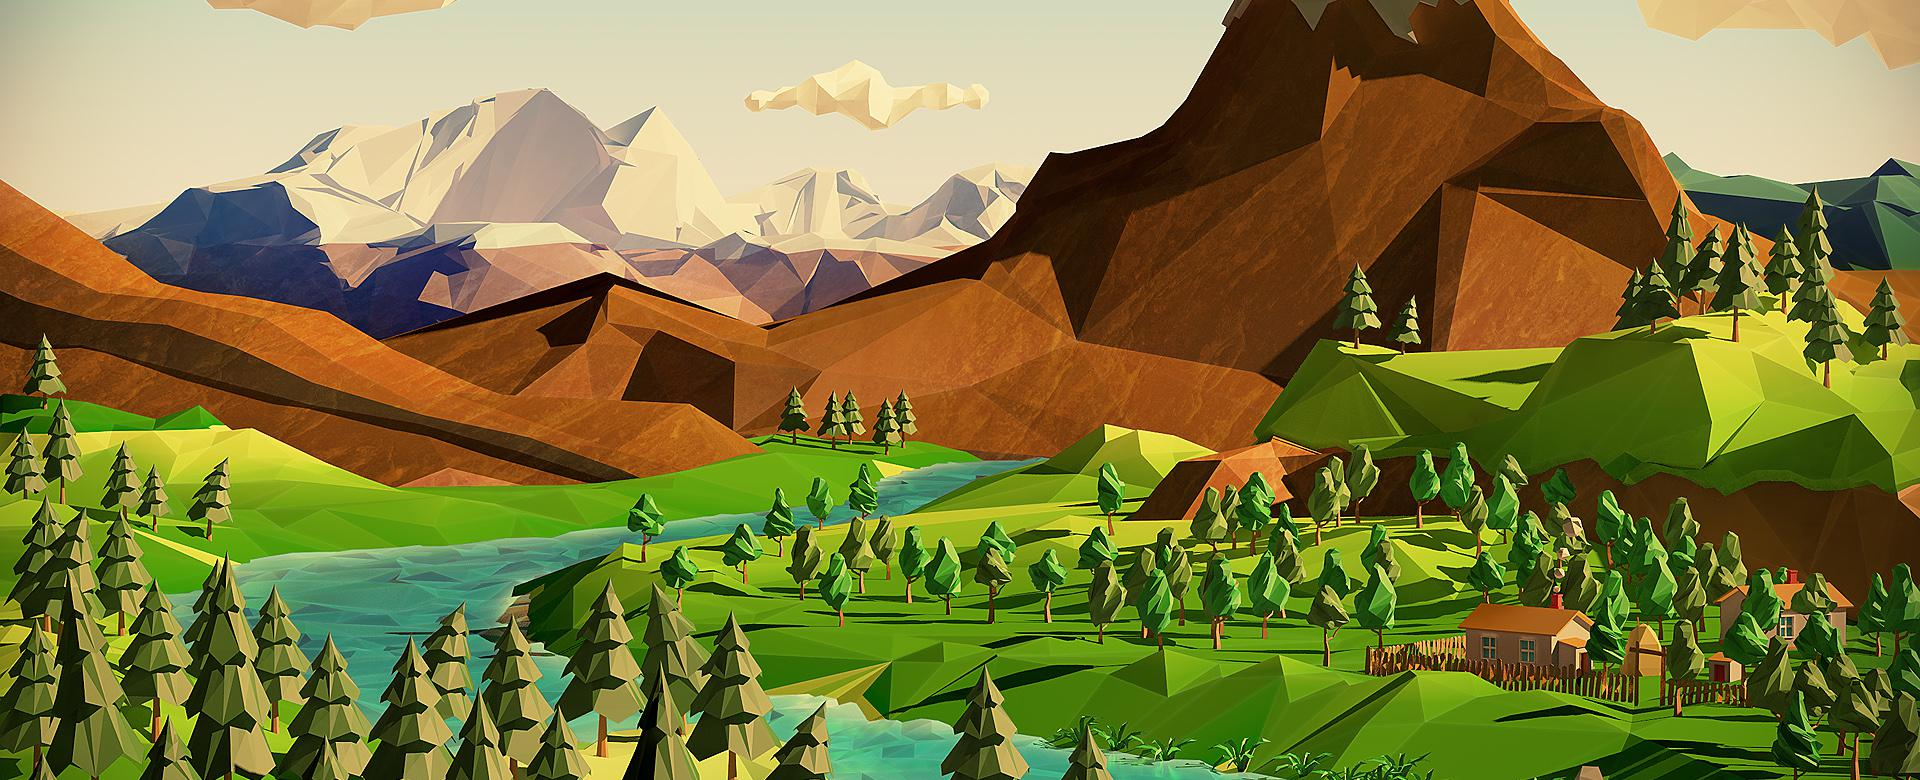

In [92]:
def _showarray(a, fmt='jpeg'):
    """
    lol, copied from tf deep dream tutorial
    """
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
image = PIL.Image.open("low-poly.jpg")
data = np.float32(image)
data = data[100:980][100:1820][:]
print(data.shape)
# data -= np.array([123.68, 116.779, 103.939], dtype=np.float32) 
_showarray(data/255.0)